In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('ErrorLog_Ver3/errorlog0601_0614_edit.csv')  
df2 = pd.read_csv('ErrorLog_Ver3/errorlog0615_0630_edit.csv')  
df3 = pd.read_csv('ErrorLog_Ver3/errorlog0701_0715_edit.csv')  
df4 = pd.read_csv('ErrorLog_Ver3/errorlog0716_0730_edit.csv')  
df5 = pd.read_csv('ErrorLog_Ver3/errorlog0731_0814_edit.csv')  
df6 = pd.read_csv('ErrorLog_Ver3/errorlog0815_0828_edit.csv')  
df7 = pd.read_csv('ErrorLog_Ver3/errorlog0829_0831_edit.csv')  

df = pd.concat([df1,df2,df3,df4,df5,df6,df7],axis=0, ignore_index=True)
print(df.shape)
df.head(5)

channel_dict = {
    0: 'Unknown',
    1: 'App Store',
    2: 'Google Play',
    3: 'Facebook',
    4: 'Amazon',
    5: 'Web',
    6: 'Apk',
    7: 'Ham',
    10: 'Huawei',
    11: 'Web_Wing',
    12: 'Google Play VN',
    13: 'Android Wallet',
    14: 'OPPO Over Sea',
    15: 'CLC APK',
    1060: 1060,
    1061: 'lapppay_IOS',
    1062: 'TwPay',
    1064: 'Twpay_IOS',
}

(12169809, 15)


In [3]:
month = [6,7,8]

EventTime = df.EventTime

date_dict = {}
for _time in EventTime:
    dt = datetime.fromtimestamp(_time)
    
    if dt.month not in month:
        continue
    
    t = f"{dt.month:02d}{dt.day:02d}-{dt.hour:02d}~{(dt.hour+1):02d}"
    
    if date_dict.get(t, 0):
        date_dict[t] += 1
    else:
        date_dict[t] = 1

error_date = []
error_count = []
for k in sorted(date_dict.keys()):
    error_date.append(k)
    error_count.append(date_dict[k])
    
print(len(error_date))

KeyboardInterrupt: 

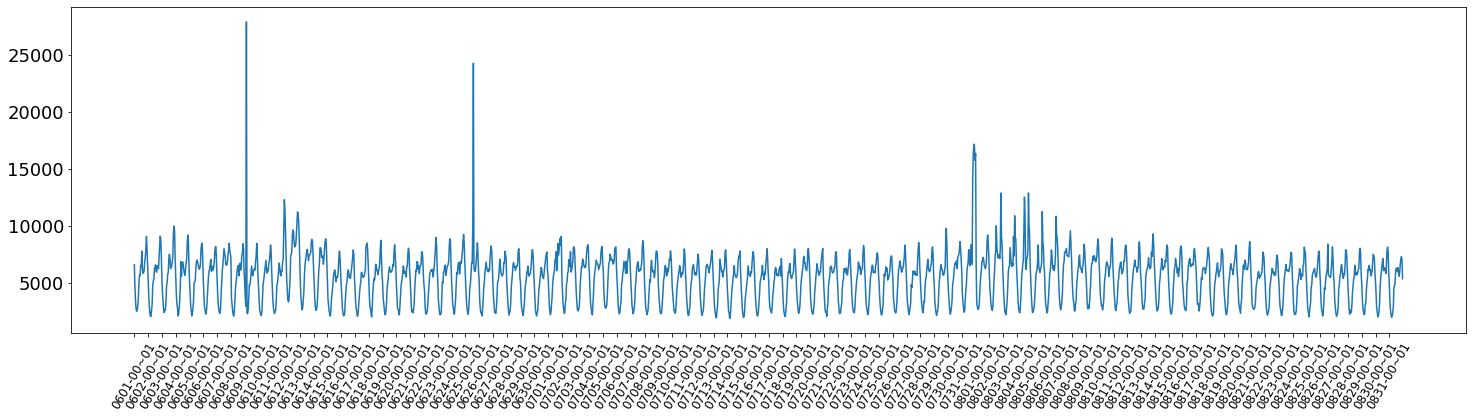

In [6]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [25, 6]
fig = plt.figure()
plt.plot(error_date, error_count)
plt.xticks(error_date[:][::24], fontsize=12, rotation=60)
plt.yticks(fontsize=18)
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def draw_acf_pacf(ts, lags=52):
    f = plt.figure(facecolor='white', figsize=(18,4))
    ax1 = f.add_subplot(121)
    plot_acf(ts, lags=lags, ax=ax1, title='ACF')
    ax2 = f.add_subplot(122)
    plot_pacf(ts, lags=lags, ax=ax2, title='PACF')
    plt.show
    
draw_acf_pacf(train, lags=120)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
import itertools
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

p_list = [24]
d_list = [0]
q_list = [0]
pdq = list(itertools.product(p_list, d_list, q_list)) 
combs = {}
aics = []

for combination in pdq:
    try:
        model = SARIMAX(train, order=combination, enforce_stationarity=False, enforce_invertibility=False)
        model = model.fit()
        combs.update({model.aic : [combination]})
        aics.append(model.aic)
        
        print(combination , ' , ', model.aic)
    except:
        continue
            
best_aic = min(aics)

In [4]:
%matplotlib inline

def plotFig(ans, time, FEATURE):
    data = ans.groupby(by=FEATURE).count()["EventTime"].nlargest(100)
    # data = data.drop([''])
    feature = data.index.tolist()
    num = data.tolist()

    lenght = np.arange(len(feature)) # colnum 長度
    if FEATURE == 'Channel' or FEATURE == 'CurChannel':
        feature = [channel_dict[_cha] for _cha in feature] # mapping編碼
    
    plt.xticks(fontsize=10, rotation="vertical")
    plt.yticks(fontsize=12)
    plt.title(f'{time} Error in {FEATURE}', fontsize=15)
    plt.bar(lenght, num, tick_label=feature) # 繪製柱狀圖
    plt.xlabel(f'{FEATURE}')
    plt.ylabel('number')
    # 標示精確數字
    for a,b in zip(lenght, num):
        plt.text(a, b, '%d' % b, ha='center', va='bottom', fontsize=9)
    
    plt.figure(figsize=(10,10))
    plt.show()

In [5]:
import time

def findMultivariate(t):
    _time = test_error_date[t]
    date, hour = _time.split('-')[0], int(_time.split('-')[1].split('~')[0])
    next_hour = hour+1 if hour<23 else 0
    s_dtime = datetime.strptime(f'2020-{date[:2]}-{date[2:]} {hour}', "%Y-%m-%d %H")
    e_dtime = datetime.strptime(f'2020-{date[:2]}-{date[2:]} {next_hour}', "%Y-%m-%d %H")
    s_time = time.mktime(s_dtime.timetuple())
    e_time = time.mktime(e_dtime.timetuple())

    ans = df.loc[(df['EventTime']>=s_time) & (df['EventTime']<=e_time)]
#     multivariate = ['Country', 'State', 'Machine', 'ErrorEventID']
    multivariate = ['Country', 'Channel', 'State', 'Machine', 'PublishVer', 'ErrorEventID', 'CurChannel']
    for multi in multivariate:
        plotFig(ans, _time, multi)

In [ ]:
%matplotlib inline
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
import itertools

train = error_count[288:1296]
# test = error_count[1296:]
# test_error_date = error_date[1296:]
test = error_count[:288]
test_error_date = error_date[:288]

# p_list = [24, 48, 72, 96, 120, 144, 168]
p_list = [24]
d_list = [0]
q_list = [0]
pdq_list = list(itertools.product(p_list, d_list, q_list)) 

for pdq in pdq_list:
    p, d, q = pdq[0], pdq[1], pdq[2]
    predict = []
    test_mse = []

    print(f"------------p = {p} | d = {d} | q = {q}-----------")

    model = SARIMAX(train, order=pdq, trend='c', enforce_stationarity=False, enforce_invertibility=False)
    np.random.seed(0)
    model_fit = model.fit()
    start = 1 # actual is p
    model_fit = model_fit.append(test[0:start])
    
    for t in range(start, len(test)):
        output = model_fit.forecast()

        pred = output[0]
        truth = test[t]
        
        loss = abs(pred - truth)
        predict.append(pred)
        test_mse.append(loss)

        if (loss < 5000):
            model_fit = model_fit.append([truth])
        else:
            model_fit = model_fit.append([pred])
#             findMultivariate(t)    

    plt.rcParams['figure.figsize'] = [25, 6]
    plt.plot(test_error_date[start:], test[start:], label='Ground truth')
    plt.plot(test_error_date[start:], predict, color='red', label='Prediction')
    plt.plot(test_error_date[start:], test_mse, color='black', label='Error')
    plt.xticks(test_error_date[start:][::24], fontsize=12, rotation = 60)
    plt.legend(loc='best')
    plt.title(f'AR p={p}, d={d}, q={q} | Error={np.asarray(test_mse).mean():.02f}',fontsize=18)
#     plt.figure(figsize=(25,6))
    plt.show()
#     plt.savefig(f"./fig/ARMA_p_{p}-d_{d}-q_{q}.png")
#     plt.close()